# Setup

In [1]:
import subprocess
# Check if packages are installed
def check_packages():
    try:
        with open('requirements.txt', 'r') as file:
            packages = file.read().splitlines()
            print(f"Packages to check: {packages}")  # Debug print
            for package in packages:
                try:
                    __import__(package)
                    print(f"{package} is already installed.")
                except ImportError:
                    print(f"{package} is not installed. Installing...")
                    subprocess.check_call(['pip', 'install', package])
                    print(f"{package} has been installed.")
    except Exception as e:
        print(f"An error occurred: {e}")  # Print any other errors

# Call the function to check and install packages
check_packages()

Packages to check: ['requests', 'aiohttp', 'pandas', 'tweepy', 'praw', 'ccxt', 'transformers', 'vaderSentiment', 'textblob', 'flask', 'plotly', 'beautifulsoup4', 'datetime', 'torch ', 'torchvision ', 'torchaudio', 'transformers', 'matplotlib', 'scikit-learn']
requests is already installed.
aiohttp is already installed.
pandas is already installed.
tweepy is already installed.
praw is already installed.
ccxt is already installed.


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


transformers is already installed.
vaderSentiment is already installed.
textblob is already installed.
flask is already installed.
plotly is already installed.
beautifulsoup4 is not installed. Installing...
beautifulsoup4 has been installed.
datetime is already installed.
torch  is not installed. Installing...
torch  has been installed.
torchvision  is not installed. Installing...
torchvision  has been installed.
torchaudio is already installed.
transformers is already installed.
matplotlib is already installed.
scikit-learn is not installed. Installing...
scikit-learn has been installed.


In [1]:
from datetime import datetime, timedelta
import time
import requests
from dotenv import load_dotenv
import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from handlers import DataHandler
from news_api import NewsAPI
from useconomyapi import USEconomyAPI
from seekingalpha import SeekingAlphaNewsAPI
from visualizations import Visualizations
from cryptopanic import CryptoPanicAPI
from cryptonewsapi import CryptoNewsAPI
from coinrankingapi import CryptoDataFetcher
from sentiment import SentimentAnalyzer

hd = DataHandler()
vz = Visualizations()
load_dotenv()

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
#for testing
from_date = 1
time_period = '24h'

# Get News Articles

## Getting Past Month News

In [3]:
from_date = 30
# Create an instance of the NewsAPI
news_api = NewsAPI(api_key=os.getenv('news_api'))
# Fetch news articles about Crypto from a specific date range
df = news_api.get_news(topic='crypto', from_date=hd.get_date_str(from_date), to_date=(hd.get_date_str(0)))
df = hd.standardize_date_format(df, 'date')

# Check if the DataFrame is not empty
if not df.empty:
    # Print the headlines along with the date and description
    print(f"{len(df)} news found")
else:
    print("No articles found for the given topic and date range.")

api = USEconomyAPI(os.getenv('useconomyapi'))
starting_date = hd.convert_to_unix_ms(hd.get_date_dt(from_date))
ending_date = hd.convert_to_unix_ms(hd.get_date_dt(0))
crypto_news_df_2 = api.fetch_news(category='economy', initial=starting_date, final=ending_date )
crypto_news_df_2 = api.format_news_data(crypto_news_df_2)


api_key = os.getenv('seeking_alpha')
seeking_alpha_api = SeekingAlphaNewsAPI(api_key)
category = 'crypto'
days =  30 # Fetch news from the last 30 days
crypto_news_df_3 = seeking_alpha_api.fetch_news_by_days(days, category)
# Check if there is any data to save
if not crypto_news_df_3.empty:
    # Save the combined data to a CSV file
    crypto_news_df_3.to_csv(f'data/crypto_30d_news_2.csv', index=False)
else:
    print("No news data collected over the specified period.")


Found 47 articles for topic: crypto
47 news found


## Older than 30 days

First date that we can get is 2 month from now..

In [1]:
from globaleconomyapi import GlobalEconomyNewsAPI
import os
import datetime
api_key = os.getenv('globaleconomy_api')

if api_key:
    api = GlobalEconomyNewsAPI(api_key)
    # Adjust date parameters for testing with past data
    initial_unix_ms = convert_to_unix_ms(2024, 1, 28)  # Example: January 1, 2023
    final_unix_ms = convert_to_unix_ms(2024, 4, 9)    # Example: April 1, 2023
    news_data = api.fetch_news('Economy', 'us')#, initial_unix_ms, final_unix_ms)
    formatted_data = api.format_news_data(news_data)
    api.save_to_csv(formatted_data, 'data/news.csv')

NameError: name 'convert_to_unix_ms' is not defined

## Getting Daily News

In [4]:
from_date = 1
auth_token = os.getenv('cryptopanic')  # Example token
crypto_panic_api = CryptoPanicAPI(auth_token)
filters = {
    'public': 'true',
    'filter': 'hot',
    'currencies': None
}
df = crypto_panic_api.format_news_data(crypto_panic_api.fetch_news(filters))

api_key = os.getenv('cryptonewsapi')
crypto_news_api = CryptoNewsAPI(api_key)
sources = ['coindesk', 'cointelegraph', 'bitcoinist', 'decrypt', 'bsc', 'theguardian']
all_news = []  # List to store data from each source
for source in sources:
    news_data = crypto_news_api.fetch_news(source) 
    if news_data:  # Ensure there is data before formatting
        formatted_data = crypto_news_api.format_news_data(news_data)
        if not formatted_data.empty:
            all_news.append(formatted_data)  # Append the formatted DataFrame to the list
# Concatenate all dataframes if all_news is not empty
if all_news:
    df_daily_news_2 = pd.concat(all_news)
    df = pd.concat([df,df_daily_news_2])

api = USEconomyAPI(os.getenv('useconomyapi'))
starting_date = hd.convert_to_unix_ms(hd.get_date_dt(from_date))
ending_date = hd.convert_to_unix_ms(hd.get_date_dt(0))
crypto_news_df_2 = api.fetch_news(category='economy', initial=starting_date, final=ending_date )
crypto_news_df_2 = api.format_news_data(crypto_news_df_2)

api_key = os.getenv('seeking_alpha')
seeking_alpha_api = SeekingAlphaNewsAPI(api_key)
crypto_news_df_3 = seeking_alpha_api.fetch_news_by_days(from_date, 'crypto')

Request sent to: https://cryptocurrency-news2.p.rapidapi.com/v1/coindesk
Received data: {'data': [{'url': 'https://www.coindesk.com/business/2024/05/04/grayscales-bitcoin-etf-sees-inflow-for-first-time-since-january-debut/?utm_medium=referral&utm_source=rss&utm_campaign=headlines', 'title': "Grayscale's Bitcoin ETF Sees First Inflow After Billions Lost Since January", 'description': "GBTC, the biggest spot bitcoin ETF, has seen its assets under management lead over BlackRock's IBIT shrink.", 'thumbnail': 'https://www.coindesk.com/resizer/GNZUswos70wxmpKht8oZbew-8qM=/800x600/cloudfront-us-east-1.images.arcpublishing.com/coindesk/R6F5BJPMOVDCRNAJ4AWTODTENU.jpg', 'createdAt': 'Sat, 04 May 2024 00:04:24 +0000'}, {'url': 'https://www.coindesk.com/policy/2024/05/03/former-cred-executives-indicted-on-wire-fraud-other-charges/?utm_medium=referral&utm_source=rss&utm_campaign=headlines', 'title': 'Former Cred Executives Indicted on Wire Fraud, Other Charges', 'description': "Daniel Schatt, a Cre

## Process Data

In [5]:
# for testing purposes Load data
#crypto_news_df = pd.read_csv('data/crypto_30d_news.csv')
#crypto_news_df_2 = pd.read_csv('data/crypto_30d_news_2.csv')
#us_economy_news = pd.read_csv('data/us_economy_30d_news.csv')

# Merge the dataframes
df = pd.concat([df, crypto_news_df_2, crypto_news_df_3])
hd.process_duplicates(df)

#for testing purposes
df.to_csv(f'data/{from_date}d_news.csv', index=False)

Duplicate Entries: 0


# Get stock prices

## Alphavantage

In [ ]:
from alpha_vantage import AlphaVantage
ALPHA_API_KEY = os.getenv('stock_api')
STOCK_ENDPOINT = 'https://www.alphavantage.co/query'
av = AlphaVantage(api_key=ALPHA_API_KEY, endpoint=STOCK_ENDPOINT)


## MarketStack API

In [4]:
from marketstack import StockPriceFetcher

#----- Stock Price Fetcher ------
fetcher = StockPriceFetcher('msft')  # Fetch end of day data for Microsoft
fetcher.fetch_price()

{'pagination': {'limit': 100, 'offset': 0, 'count': 100, 'total': 252}, 'data': {'name': 'Microsoft Corporation', 'symbol': 'MSFT', 'country': None, 'has_intraday': False, 'has_eod': True, 'eod': [{'open': 421.05, 'high': 421.87, 'low': 419.14, 'close': 420.72, 'volume': 21711778.0, 'adj_high': 421.87, 'adj_low': 419.12, 'adj_close': 420.72, 'adj_open': 420.96, 'adj_volume': 21871161.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'MSFT', 'exchange': 'XNAS', 'date': '2024-03-28T00:00:00+0000'}, {'open': 424.2, 'high': 424.4, 'low': 419.01, 'close': 421.43, 'volume': 16679715.0, 'adj_high': 424.45, 'adj_low': 419.01, 'adj_close': 421.43, 'adj_open': 424.44, 'adj_volume': 16704978.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'MSFT', 'exchange': 'XNAS', 'date': '2024-03-27T00:00:00+0000'}, {'open': 425.61, 'high': 425.99, 'low': 421.35, 'close': 421.65, 'volume': 16690800.0, 'adj_high': 425.99, 'adj_low': 421.35, 'adj_close': 421.65, 'adj_open': 425.61, 'adj_volume': 16725647.0, 

# Get Crypto Information
## Crypto API

In [1]:
from crypto_api import CryptoAPI

api = CryptoAPI()
api.get_crypto_listings()
api.save_crypto_listings_to_csv()

Number of cryptocurrencies: 3119
CSV file saved successfully


In [15]:
#for testing purposes
from_date = 1

category = input("For which category do you want to analyse the sentiment ? Options are : 'meme', ")

api_key = os.getenv('coinranking') 

if from_date == 30:
    time_period = '30d'
else:
    time_period = '24h'

fetcher = CryptoDataFetcher(api_key, default_tags=category, default_limit=50, default_time_period=f"{time_period}")
price_data = fetcher.fetch_all_history()

if not price_data.empty:
    fetcher.write_to_csv(price_data, f'data/{time_period}_{fetcher.default_limit}{category}_history.csv')
else:
    print("No data fetched.")

Fetching historical data for Dogecoin with UUID a91GCGd_u96cF...
Request URL: https://coinranking1.p.rapidapi.com/coin/a91GCGd_u96cF/history?timePeriod=24h
Status Code: 200
Fetching historical data for Shiba Inu with UUID xz24e0BjL...
Request URL: https://coinranking1.p.rapidapi.com/coin/xz24e0BjL/history?timePeriod=24h
Status Code: 200
Fetching historical data for PEPE with UUID 03WI8NQPF...
Request URL: https://coinranking1.p.rapidapi.com/coin/03WI8NQPF/history?timePeriod=24h
Status Code: 200
Fetching historical data for dogwifhat with UUID sZUrmToWF...
Request URL: https://coinranking1.p.rapidapi.com/coin/sZUrmToWF/history?timePeriod=24h
Status Code: 200
Fetching historical data for FLOKI with UUID fmHk13Rqw...
Request URL: https://coinranking1.p.rapidapi.com/coin/fmHk13Rqw/history?timePeriod=24h
Status Code: 200
Fetching historical data for Baby Doge Coin with UUID JY1_q2c0g...
Request URL: https://coinranking1.p.rapidapi.com/coin/JY1_q2c0g/history?timePeriod=24h
Status Code: 200
F

In [17]:
#df.to_csv(f'data/{time_period}_news.csv', index=False) #for testing

# Sentiment

## Apply Finbert

In [6]:
#for testing purposes
#df = pd.read_csv("data/30d_news.csv")

# Initialize SentimentAnalyzer
analyzer = SentimentAnalyzer()
sentiment_data = analyzer.add_sentiments_to_df(df)

In [8]:
#for testing purposes
df.to_csv(f'data/{time_period}_news_with_sentiment.csv', index=False)

## Sentiment Weighting:
Develop a weighting system for different sources or types of news based on their historical accuracy and impact on market prices. This can help prioritize more influential data points in your analysis.

In [13]:
sentiment_data.head()

,Average Sentiment
Date,
2024-05-03 16:55:10,0.380383
2024-05-03 17:11:27,0.774858
2024-05-03 17:26:50,0.051341
2024-05-03 17:35:38,0.359186
2024-05-03 17:38:56,0.046423


# Vizualisations

## Average Sentiment per Day and Normalize Price

In [3]:
#for testing purposes
sentiment_data = pd.read_csv(f"data/24h_news_with_sentiment.csv")
price_data = pd.read_csv('data/24h_50meme_history.csv')

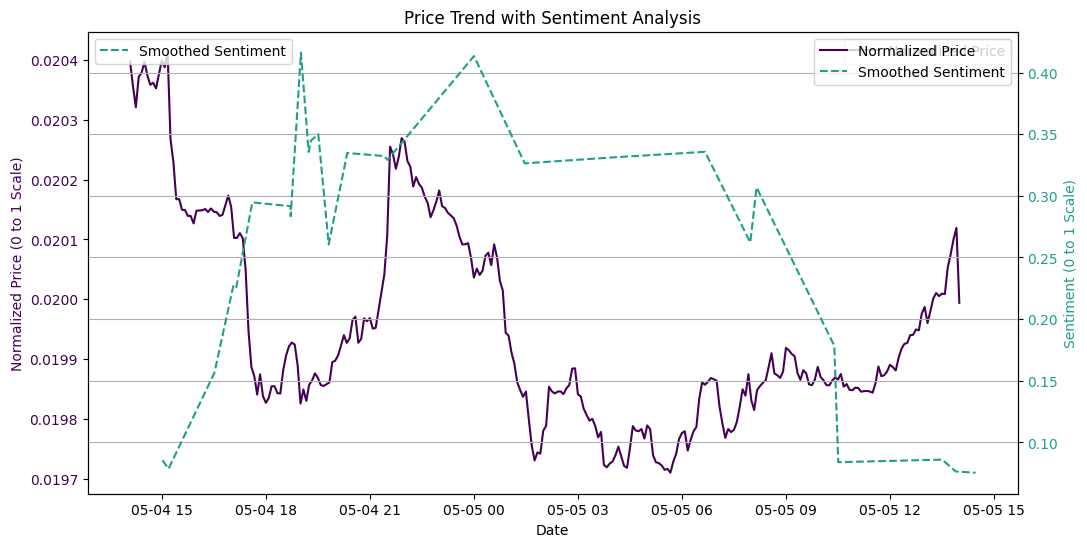

In [4]:
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

# Analysis 1d

In [5]:
# Calculate percentage price change directly from normalized prices
price_data['price_change'] = price_data['normalized price'].pct_change() * 100
price_data['price_change'] = price_data['price_change'].fillna(0)  # Replace NaN values with 0

# Resample price data to 5-minute intervals, forward filling the last known prices and changes
price_data_resampled = price_data.resample('5min').last().ffill()

# Round sentiment data timestamps to the nearest 5 minutes
sentiment_data.index = sentiment_data.index.round('5min')

# Merge using merge_asof to align sentiment data with the nearest price data
combined_data = pd.merge_asof(sentiment_data.sort_index(), price_data_resampled.reset_index(), 
                              left_index=True, right_on='timestamp', direction='forward')

# Since we need the next period's price change, shift the 'price_change' column by -1
combined_data['Next 5min Price Change'] = combined_data['price_change'].shift(-1)

# Rename columns to match function expectations
combined_data.rename(columns={'Average Sentiment': 'Average Sentiment'}, inplace=True)

# Drop the 'timestamp' and original 'price_change' columns if not needed
combined_data.drop(columns=['timestamp', 'price_change'], inplace=True)

combined_data

,Average Sentiment,normalized price,Next 5min Price Change
Date,,,
2024-05-04 14:00:00,0.069306,0.020398,0.000000
2024-05-04 14:05:00,0.141512,0.020398,-0.204000
2024-05-04 14:10:00,0.070901,0.020356,-0.204000
2024-05-04 14:10:00,0.027809,0.020356,-0.173633
2024-05-04 14:15:00,0.158687,0.020321,0.111204
2024-05-04 15:00:00,0.042699,0.020399,0.111204
2024-05-04 15:00:00,0.087833,0.020399,0.119003
2024-05-04 15:10:00,0.020818,0.020412,-0.027070
2024-05-04 16:30:00,0.685777,0.020146,-0.255534


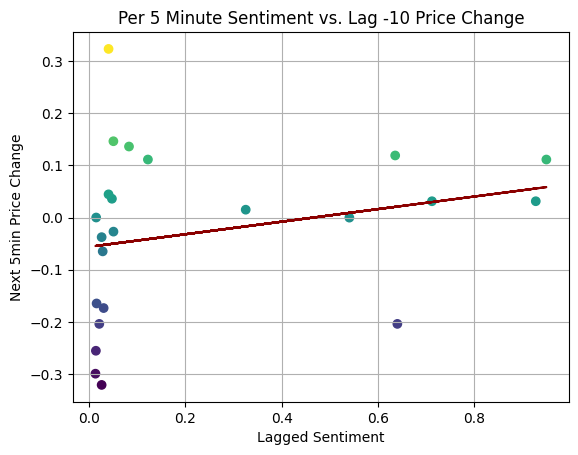

Correlation with -10 5min(s) lag: 0.24

Average Price Change on High Sentiment 5mins: -1 %
Average Price Change on Low Sentiment 5mins: -4 %

Predictive Power of Sentiment on Price:
R-squared: 0.06
AIC: -16.91
P-value of Lagged Sentiment variable: 0.27


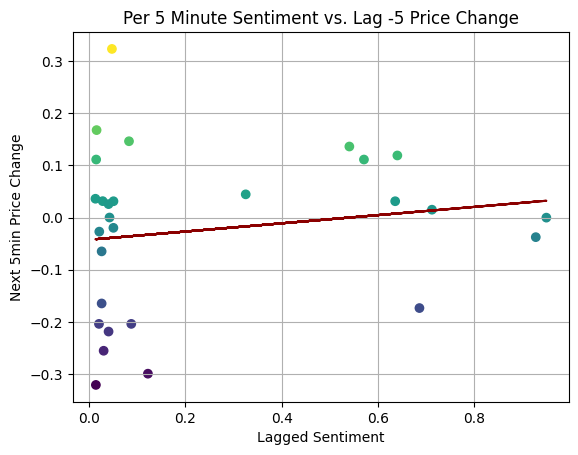

Correlation with -5 5min(s) lag: 0.16

Average Price Change on High Sentiment 5mins: 0 %
Average Price Change on Low Sentiment 5mins: -4 %

Predictive Power of Sentiment on Price:
R-squared: 0.03
AIC: -22.36
P-value of Lagged Sentiment variable: 0.42


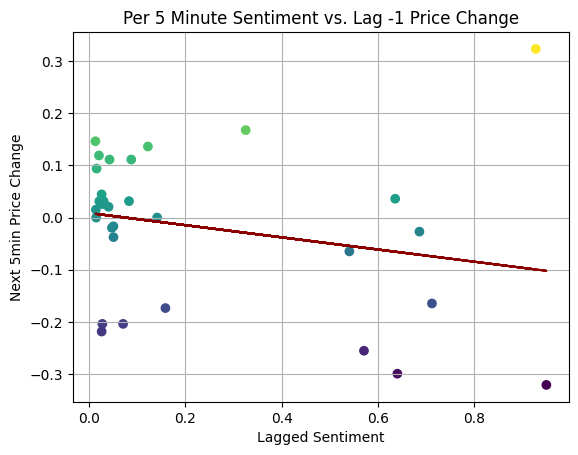

Correlation with -1 5min(s) lag: -0.24

Average Price Change on High Sentiment 5mins: -2 %
Average Price Change on Low Sentiment 5mins: -2 %

Predictive Power of Sentiment on Price:
R-squared: 0.06
AIC: -28.62
P-value of Lagged Sentiment variable: 0.2


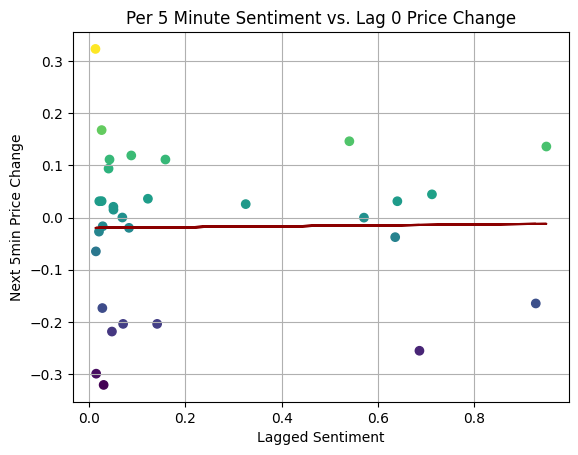

Correlation with 0 5min(s) lag: 0.02

Average Price Change on High Sentiment 5mins: -2 %
Average Price Change on Low Sentiment 5mins: -2 %

Predictive Power of Sentiment on Price:
R-squared: 0.0
AIC: -26.85
P-value of Lagged Sentiment variable: 0.93


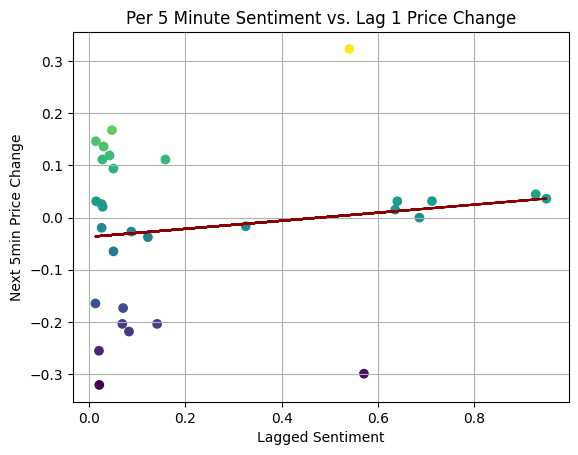

Correlation with 1 5min(s) lag: 0.15

Average Price Change on High Sentiment 5mins: -2 %
Average Price Change on Low Sentiment 5mins: -2 %

Predictive Power of Sentiment on Price:
R-squared: 0.02
AIC: -25.61
P-value of Lagged Sentiment variable: 0.41


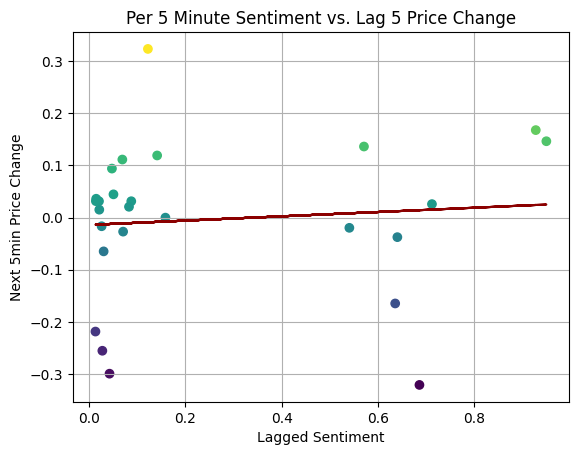

Correlation with 5 5min(s) lag: 0.09

Average Price Change on High Sentiment 5mins: 1 %
Average Price Change on Low Sentiment 5mins: -1 %

Predictive Power of Sentiment on Price:
R-squared: 0.01
AIC: -22.43
P-value of Lagged Sentiment variable: 0.67


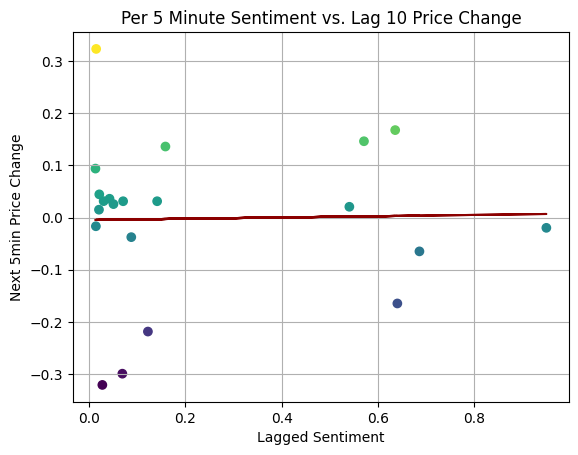

Correlation with 10 5min(s) lag: 0.02

Average Price Change on High Sentiment 5mins: 2 %
Average Price Change on Low Sentiment 5mins: -2 %

Predictive Power of Sentiment on Price:
R-squared: 0.0
AIC: -16.53
P-value of Lagged Sentiment variable: 0.92


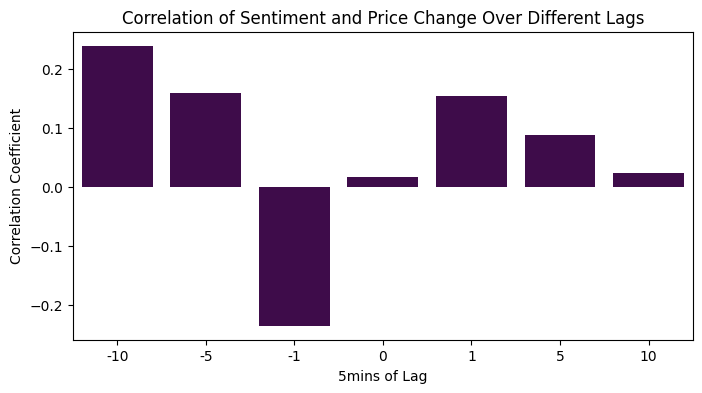

In [6]:
vz.analysis(combined_data, from_date)

# Analysis 30d

To address how the price change is calculated and ensure accuracy, let's clarify the method. The price change between two days is typically calculated using the formula:

Price Change (%) = ((Current Day Price−Previous Day Price) / Previous Day Price ) × 100

This formula captures the percentage change from one day to the next, which is ideal for analyzing how daily variations in price relate to other factors like sentiment.

Analyse how the variable Average Sentiment of a day influence the variable Price change.

In [7]:
# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['Average Sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'Average Sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates

### Lag Analysis
Shift the sentiment data by various time periods (both forward and backward) to see if the correlation improves when assuming a delayed effect of sentiment on prices.
Experiment with different lags between sentiment data and price data. Often, market reactions to news or events are not immediate. Analyzing the effect of sentiment over different time lags (e.g., 1 day, 2 days, 1 week) might reveal stronger correlations.

- **Lagging Sentiment Data Backward (Negative Lag)**
Concept: When we lag sentiment data backward (using a negative lag), we are effectively shifting sentiment data to later dates. This method is used when you suspect that sentiment influences future price changes. For example, if we use a lag of -1 day, the sentiment data from January 1st is aligned with the price change of January 2nd. This is based on the hypothesis that today's sentiment will affect tomorrow's price changes.
This approach is suitable if we are testing the hypothesis that the market reacts to sentiment after a delay. It helps to identify if changes in sentiment can predict subsequent movements in prices.
- **Lagging Sentiment Data Forward (Positive Lag)**
Concept: Lagging sentiment data forward (using a positive lag) means we shift sentiment data to earlier dates. This scenario is used to examine if past sentiment changes are reflected in current or future price changes. For instance, if we set a lag of +1 day, the sentiment from January 2nd is used in conjunction with the price change of January 1st. This might seem counterintuitive at first, as it suggests looking at how previous price changes correlate with future sentiment but can be insightful for retrospective analyses, such as studying whether price changes lead to a detectable shift in sentiment, perhaps due to investor reactions or feedback loops in market behavior.

#### Procedure
- **Plotting Correlation**
Plotting sentiment against price change can help visually identify patterns or trends, such as whether lower sentiments tend to coincide with negative price changes.
- **Descriptive Statistics**
 Compute and compare averages or percent changes across different conditions. For example, comparing average price changes on days with particularly high or low sentiments.
 - **Daily Regression Analysis**
We could use regression techniques  to see how changes in sentiment predict changes in price.
- **Weekly Regression Analysis**
As daily correlation might not provide the best results, we could use regression techniques over a period (e.g., weekly, monthly) to see how changes in sentiment predict changes in price.

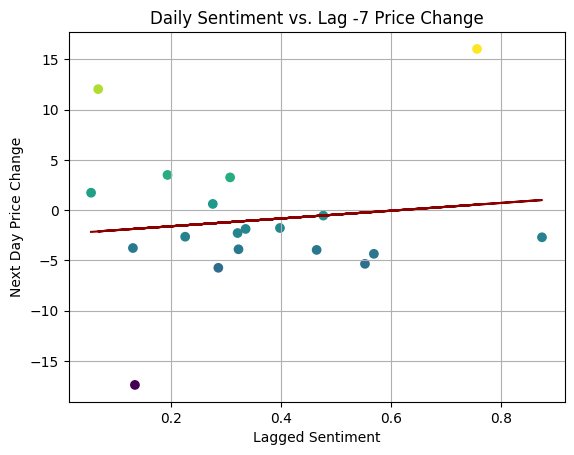

Correlation with -7 day(s) lag: 0.12

Average Price Change on High Sentiment Days: -124 %
Average Price Change on Low Sentiment Days: -78 %

Predictive Power of Sentiment on Price:
R-squared: 0.02
AIC: 130.13
P-value of Lagged Sentiment variable: 0.62

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.3
AIC: 20.2
P-value of Lagged Sentiment variable: 0.45


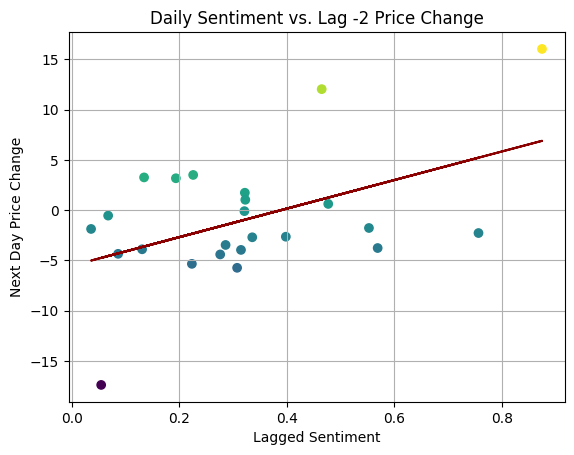

Correlation with -2 day(s) lag: 0.48

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -53 %

Predictive Power of Sentiment on Price:
R-squared: 0.23
AIC: 152.8
P-value of Lagged Sentiment variable: 0.02

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.5
AIC: 21.44
P-value of Lagged Sentiment variable: 0.18


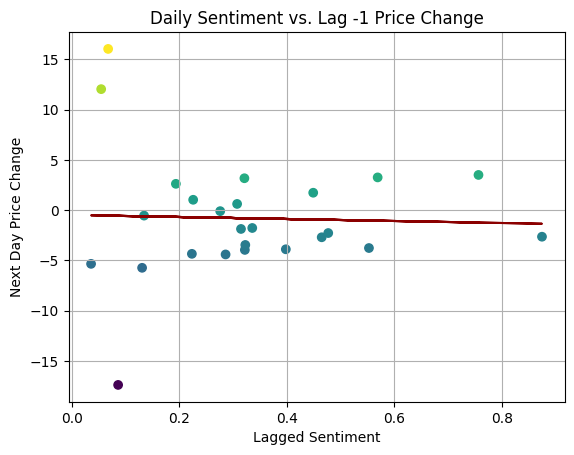

Correlation with -1 day(s) lag: -0.03

Average Price Change on High Sentiment Days: -136 %
Average Price Change on Low Sentiment Days: -29 %

Predictive Power of Sentiment on Price:
R-squared: 0.0
AIC: 164.92
P-value of Lagged Sentiment variable: 0.87

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.6
AIC: 20.34
P-value of Lagged Sentiment variable: 0.12


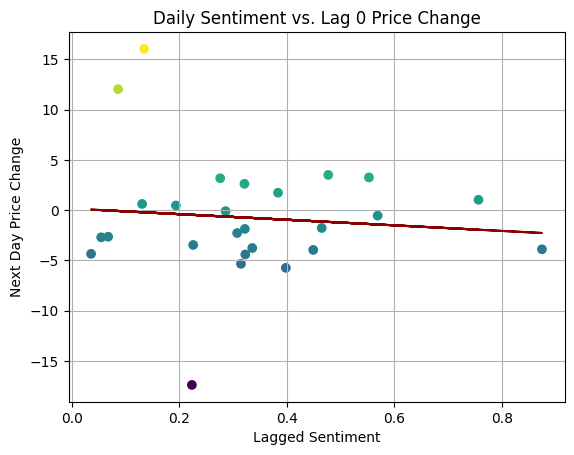

Correlation with 0 day(s) lag: -0.09

Average Price Change on High Sentiment Days: -106 %
Average Price Change on Low Sentiment Days: -45 %

Predictive Power of Sentiment on Price:
R-squared: 0.01
AIC: 170.18
P-value of Lagged Sentiment variable: 0.65

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.17
AIC: 24.05
P-value of Lagged Sentiment variable: 0.49


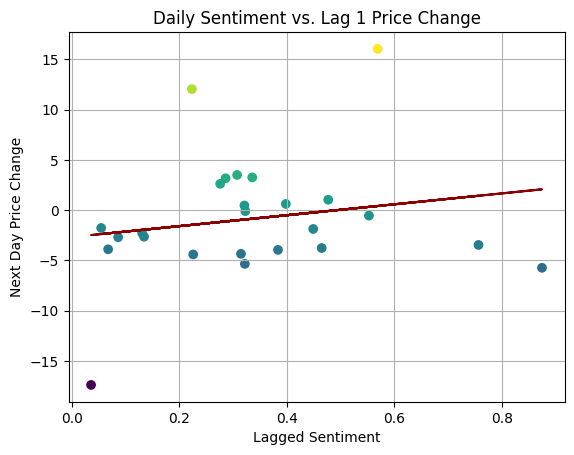

Correlation with 1 day(s) lag: 0.18

Average Price Change on High Sentiment Days: -129 %
Average Price Change on Low Sentiment Days: -45 %

Predictive Power of Sentiment on Price:
R-squared: 0.03
AIC: 163.96
P-value of Lagged Sentiment variable: 0.38

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.06
AIC: 20.36
P-value of Lagged Sentiment variable: 0.76


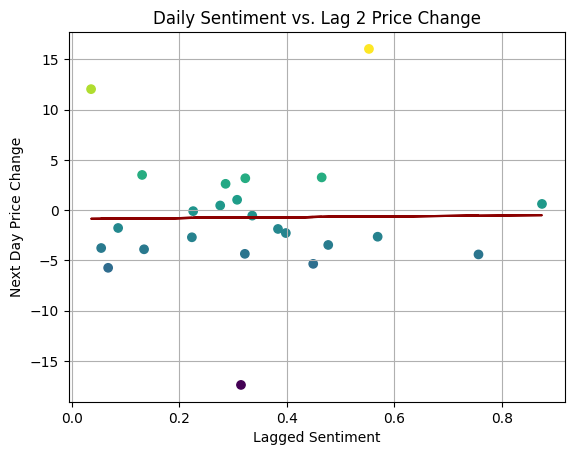

Correlation with 2 day(s) lag: 0.01

Average Price Change on High Sentiment Days: -141 %
Average Price Change on Low Sentiment Days: -4 %

Predictive Power of Sentiment on Price:
R-squared: 0.0
AIC: 159.09
P-value of Lagged Sentiment variable: 0.95

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.58
AIC: 16.98
P-value of Lagged Sentiment variable: 0.24


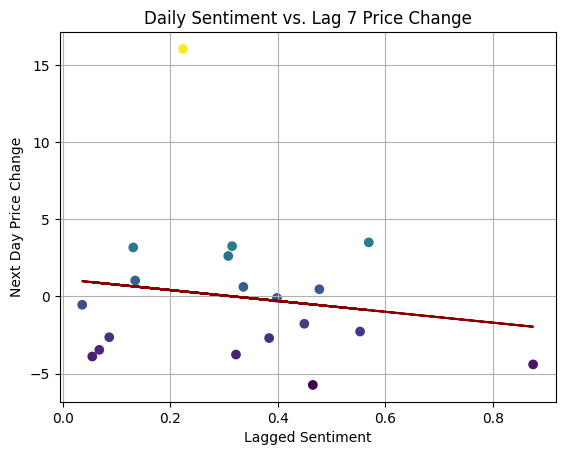

Correlation with 7 day(s) lag: -0.16

Average Price Change on High Sentiment Days: -137 %
Average Price Change on Low Sentiment Days: 118 %

Predictive Power of Sentiment on Price:
R-squared: 0.03
AIC: 116.03
P-value of Lagged Sentiment variable: 0.52

Predictive Power of Sentiment on Price, over a 1 week period:
R-squared: 0.18
AIC: 18.83
P-value of Lagged Sentiment variable: 0.58


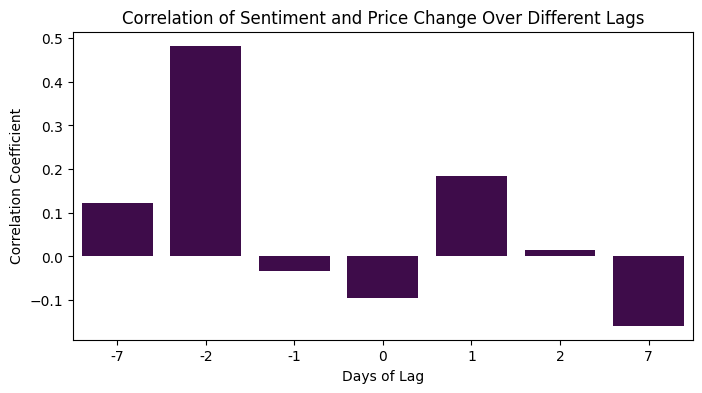

In [6]:
vz.analysis(combined_data, from_date)

### Enhancement
1. Volatility and Outliers: If either the price data or the sentiment data is more volatile or has outliers, it can skew the correlation. For example, a few large jumps or drops in price might not be directly linked to sentiment but could still heavily influence the correlation calculation.
3. Noise in Data: The sentiment scores might contain noise due to the inherent subjectivity and complexity of natural language processing. This noise can dilute real correlations with price movements.
4. Non-linear Relationships: The relationship between sentiment and prices might be non-linear, meaning that while they do move together, the relationship might not be directly proportional or consistent across the whole range of data.
5. Averaging and Smoothing: Both the averaging of sentiment over time and the smoothing could be masking more nuanced interactions between individual spikes in sentiment and corresponding price changes.

# Cross-validation with Other Data:
Validate sentiment analysis results with other market indicators like trading volume, market cap changes, or macroeconomic indicators. This cross-validation can help confirm the reliability of sentiment analysis.